# Entraînement du MusicTransformer

In [1]:
# Imports
import sys
from pathlib import Path
import json
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# On ajoute le odssier src au path
sys.path.append(str(Path.cwd().parent / 'src'))

from models.lightning_module import MusicTransformerLightning
from data.dataset import create_dataloaders

# Configuration matplotlib
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Imports réussis")
print(f"PyTorch version: {torch.__version__}")
print(f"Lightning version: {pl.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Imports réussis
PyTorch version: 2.10.0.dev20251124+cu128
Lightning version: 2.5.6
CUDA disponible: True
GPU: NVIDIA GeForce RTX 5070 Laptop GPU


## 1. Configuration de l'Entraînement

In [2]:
# Chemins
DATA_DIR = Path("../src/data/processed")
CHECKPOINT_DIR = Path("../checkpoints")
LOG_DIR = Path("../logs")

# Créer les dossiers
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True) # Pour enregistrer chaque epoques
LOG_DIR.mkdir(parents=True, exist_ok=True) # Pour enregistrer les logs

# Hyperparamètres du modèle
MODEL_CONFIG = {
    'd_model': 512, # dimension des embeddings
    'num_heads': 8, # nombre de têtes d'attention
    'num_layers': 6, # nombre de couches Transformer
    'd_ff': 2048, # dimension du feed-forward
    'dropout': 0.1, # taux de dropout
    'max_seq_len': 1024 # longueur max des séquences
}

# Hyperparamètres d'entraînement
TRAINING_CONFIG = {
    'batch_size': 8,
    'learning_rate': 1e-4,
    'weight_decay': 0.01, # Pour éviter l'overfitting
    'warmup_steps': 4000, # nombre de pas pour le warmup (learning rate progressif)
    'epochs': 20,
    'num_workers': 4, # Processus de chargement en parallèle
    'gpus': 1 if torch.cuda.is_available() else 0,
    'precision': '32',
    'accumulate_grad_batches': 1 # pour simuler un plus grand batch size (accumuler les gradients sur plusieurs batches)
}


SEED = 42 # Le secret de la vie haha
pl.seed_everything(SEED)

print("Modèle:")
for k, v in MODEL_CONFIG.items():
    print(f"  {k:15s}: {v}")

print("\n Entraînement:")
for k, v in TRAINING_CONFIG.items():
    print(f"  {k:25s}: {v}")

Seed set to 42


Modèle:
  d_model        : 512
  num_heads      : 8
  num_layers     : 6
  d_ff           : 2048
  dropout        : 0.1
  max_seq_len    : 1024

 Entraînement:
  batch_size               : 8
  learning_rate            : 0.0001
  weight_decay             : 0.01
  warmup_steps             : 4000
  epochs                   : 20
  num_workers              : 4
  gpus                     : 1
  precision                : 32
  accumulate_grad_batches  : 1


## 2. Chargement des Données

In [3]:
# On charge les métadonnées du preprocessing

with open(DATA_DIR / "preprocessing_info.json", 'r') as f:
    preprocessing_info = json.load(f)

vocab_size = preprocessing_info['vocab_size']

print("Métadonnées chargées :")
print(f"Vocabulaire : {vocab_size} tokens")
print(f"Tokenizer : {preprocessing_info['tokenizer_type']}")
print(f"Max seq len : {preprocessing_info['max_seq_len']}")
print(f"Train séquences : {preprocessing_info['train_sequences']}")
print(f"Val séquences : {preprocessing_info['val_sequences']}")
print(f"Test séquences : {preprocessing_info['test_sequences']}")

Métadonnées chargées :
Vocabulaire : 453 tokens
Tokenizer : REMI
Max seq len : 1024
Train séquences : 42318
Val séquences : 4801
Test séquences : 5534


In [4]:
# Créer les DataLoaders

train_loader, val_loader = create_dataloaders(
    train_sequences_path=DATA_DIR / "train_sequences.pkl",
    val_sequences_path=DATA_DIR / "validation_sequences.pkl",
    batch_size=TRAINING_CONFIG['batch_size'],
    max_seq_len=MODEL_CONFIG['max_seq_len'],
    num_workers=TRAINING_CONFIG['num_workers'],
    pin_memory=(TRAINING_CONFIG['gpus'] > 0)
)

print(f"DataLoaders créés")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Steps par epoch: {len(train_loader)}")
print(f"Total steps ({TRAINING_CONFIG['epochs']} epochs): {len(train_loader) * TRAINING_CONFIG['epochs']}")

📂 Chargement des séquences depuis: ..\src\data\processed\train_sequences.pkl
✓ 42318 séquences chargées
  Longueur moyenne: 1001.8 tokens
  Longueur min/max: 32/1024 tokens
📂 Chargement des séquences depuis: ..\src\data\processed\validation_sequences.pkl
✓ 4801 séquences chargées
  Longueur moyenne: 996.3 tokens
  Longueur min/max: 41/1024 tokens

✓ DataLoaders créés:
  Train: 42318 séquences, 5289 batchs
  Val:   4801 séquences, 601 batchs
DataLoaders créés
Train batches: 5289
Val batches: 601
Steps par epoch: 5289
Total steps (20 epochs): 105780


## 3. Création du Modèle

In [5]:
# Création du modèle

model = MusicTransformerLightning(
    vocab_size=vocab_size,
    d_model=MODEL_CONFIG['d_model'],
    num_heads=MODEL_CONFIG['num_heads'],
    num_layers=MODEL_CONFIG['num_layers'],
    d_ff=MODEL_CONFIG['d_ff'],
    max_seq_len=MODEL_CONFIG['max_seq_len'],
    dropout=MODEL_CONFIG['dropout'],
    learning_rate=TRAINING_CONFIG['learning_rate'],
    warmup_steps=TRAINING_CONFIG['warmup_steps'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

num_params = model.model.count_parameters()

print(f"Modèle créé")
print(f"Vocabulaire: {vocab_size:,} tokens")
print(f"Paramètres entraînables: {num_params:,}")
print(f"Taille estimée (poids): {(num_params * 4) / (1024**2):.1f} MB")

# Afficher l'architecture
print(f"Architecture:")
print(f"Token Embedding: {vocab_size} → {MODEL_CONFIG['d_model']}")
print(f"Positional Encoding: {MODEL_CONFIG['max_seq_len']}")
print(f"Transformer Blocks: {MODEL_CONFIG['num_layers']} layers")
print(f"    Multi-Head Attention: {MODEL_CONFIG['num_heads']} heads")
print(f"    Feed-Forward: {MODEL_CONFIG['d_model']} → {MODEL_CONFIG['d_ff']} → {MODEL_CONFIG['d_model']}")
print(f"    Dropout: {MODEL_CONFIG['dropout']}")
print(f"Output Layer: {MODEL_CONFIG['d_model']} → {vocab_size}")

Modèle créé
Vocabulaire: 453 tokens
Paramètres entraînables: 19,378,629
Taille estimée (poids): 73.9 MB
Architecture:
Token Embedding: 453 → 512
Positional Encoding: 1024
Transformer Blocks: 6 layers
    Multi-Head Attention: 8 heads
    Feed-Forward: 512 → 2048 → 512
    Dropout: 0.1
Output Layer: 512 → 453


## 4. Configuration du Trainer Lightning

In [6]:
# Callbacks

# 1. ModelCheckpoint: sauvegarde les meilleurs modèles
checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename='music-transformer-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True
)

# 2. EarlyStopping: arrête si pas d'amélioration
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=True
)

# 3. LearningRateMonitor: log le learning rate
lr_monitor = LearningRateMonitor(logging_interval='step')

# Logger TensorBoard
logger = TensorBoardLogger(
    save_dir=LOG_DIR,
    name='music_transformer'
)

print("Callbacks et logger configurés")

Callbacks et logger configurés


In [7]:
# On crée le Trainer

trainer = pl.Trainer(
    max_epochs=TRAINING_CONFIG['epochs'],
    accelerator='gpu' if TRAINING_CONFIG['gpus'] > 0 else 'cpu',
    devices=TRAINING_CONFIG['gpus'] if TRAINING_CONFIG['gpus'] > 0 else 1,
    precision=TRAINING_CONFIG['precision'],
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    logger=logger,
    accumulate_grad_batches=TRAINING_CONFIG['accumulate_grad_batches'],
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    val_check_interval=1.0,
    deterministic=True,
    enable_progress_bar=True
)

print("Trainer créé")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Trainer créé


## 5. Lancement de l'Entraînement

In [8]:
# Entraînement
trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

print("Entrînement terminé")

You are using a CUDA device ('NVIDIA GeForce RTX 5070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\jerem\Desktop\Projet_DL_Torch\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\jerem\Desktop\Projet_DL_Torch\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MusicTransformer | 19.4 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
19.4 M    Trainable params
0         Non-trainable params
19.4 M    Total params
77.515    Total estimated 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\jerem\Desktop\Projet_DL_Torch\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
c:\Users\jerem\Desktop\Projet_DL_Torch\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\jerem\Desktop\Projet_DL_Torch\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\jerem\Desktop\Projet_DL_Torch\.venv\Lib\site-packages\pytorch_lightning\callbacks\lr_monitor.py:217: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 2.573
Epoch 0, global step 5289: 'val_loss' reached 2.57271 (best 2.57271), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=00-val_loss=2.5727.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.207 >= min_delta = 0.0. New best score: 2.365
Epoch 1, global step 10578: 'val_loss' reached 2.36535 (best 2.36535), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=01-val_loss=2.3654.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.139 >= min_delta = 0.0. New best score: 2.227
Epoch 2, global step 15867: 'val_loss' reached 2.22685 (best 2.22685), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=02-val_loss=2.2268.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 2.142
Epoch 3, global step 21156: 'val_loss' reached 2.14201 (best 2.14201), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=03-val_loss=2.1420.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 2.070
Epoch 4, global step 26445: 'val_loss' reached 2.06987 (best 2.06987), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=04-val_loss=2.0699.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 2.012
Epoch 5, global step 31734: 'val_loss' reached 2.01207 (best 2.01207), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=05-val_loss=2.0121.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.971
Epoch 6, global step 37023: 'val_loss' reached 1.97087 (best 1.97087), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=06-val_loss=1.9709.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.933
Epoch 7, global step 42312: 'val_loss' reached 1.93266 (best 1.93266), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=07-val_loss=1.9327.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.904
Epoch 8, global step 47601: 'val_loss' reached 1.90435 (best 1.90435), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=08-val_loss=1.9044.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.879
Epoch 9, global step 52890: 'val_loss' reached 1.87904 (best 1.87904), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=09-val_loss=1.8790.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.859
Epoch 10, global step 58179: 'val_loss' reached 1.85948 (best 1.85948), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=10-val_loss=1.8595.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.843
Epoch 11, global step 63468: 'val_loss' reached 1.84286 (best 1.84286), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=11-val_loss=1.8429.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.826
Epoch 12, global step 68757: 'val_loss' reached 1.82575 (best 1.82575), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=12-val_loss=1.8258.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.813
Epoch 13, global step 74046: 'val_loss' reached 1.81252 (best 1.81252), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=13-val_loss=1.8125.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.800
Epoch 14, global step 79335: 'val_loss' reached 1.80036 (best 1.80036), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=14-val_loss=1.8004.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.788
Epoch 15, global step 84624: 'val_loss' reached 1.78839 (best 1.78839), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=15-val_loss=1.7884.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.785
Epoch 16, global step 89913: 'val_loss' reached 1.78501 (best 1.78501), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=16-val_loss=1.7850.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.774
Epoch 17, global step 95202: 'val_loss' reached 1.77435 (best 1.77435), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=17-val_loss=1.7744.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.766
Epoch 18, global step 100491: 'val_loss' reached 1.76629 (best 1.76629), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=18-val_loss=1.7663.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.763
Epoch 19, global step 105780: 'val_loss' reached 1.76290 (best 1.76290), saving model to 'C:\\Users\\jerem\\Desktop\\Projet_DL_Torch\\checkpoints\\music-transformer-epoch=19-val_loss=1.7629.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=20` reached.


Entrînement terminé


## 6. Résultats de l'Entraînement

In [9]:
# Meilleur modèle
best_model_path = trainer.checkpoint_callback.best_model_path
best_val_loss = trainer.checkpoint_callback.best_model_score

print("Meilleur modèle:")
print(f"Chemin: {best_model_path}")
print(f"Val loss: {best_val_loss:.4f}")
print(f"Val perplexity: {np.exp(best_val_loss.item()):.2f}")

Meilleur modèle:
Chemin: C:\Users\jerem\Desktop\Projet_DL_Torch\checkpoints\music-transformer-epoch=19-val_loss=1.7629.ckpt
Val loss: 1.7629
Val perplexity: 5.83


## 7. Visualisation des Métriques

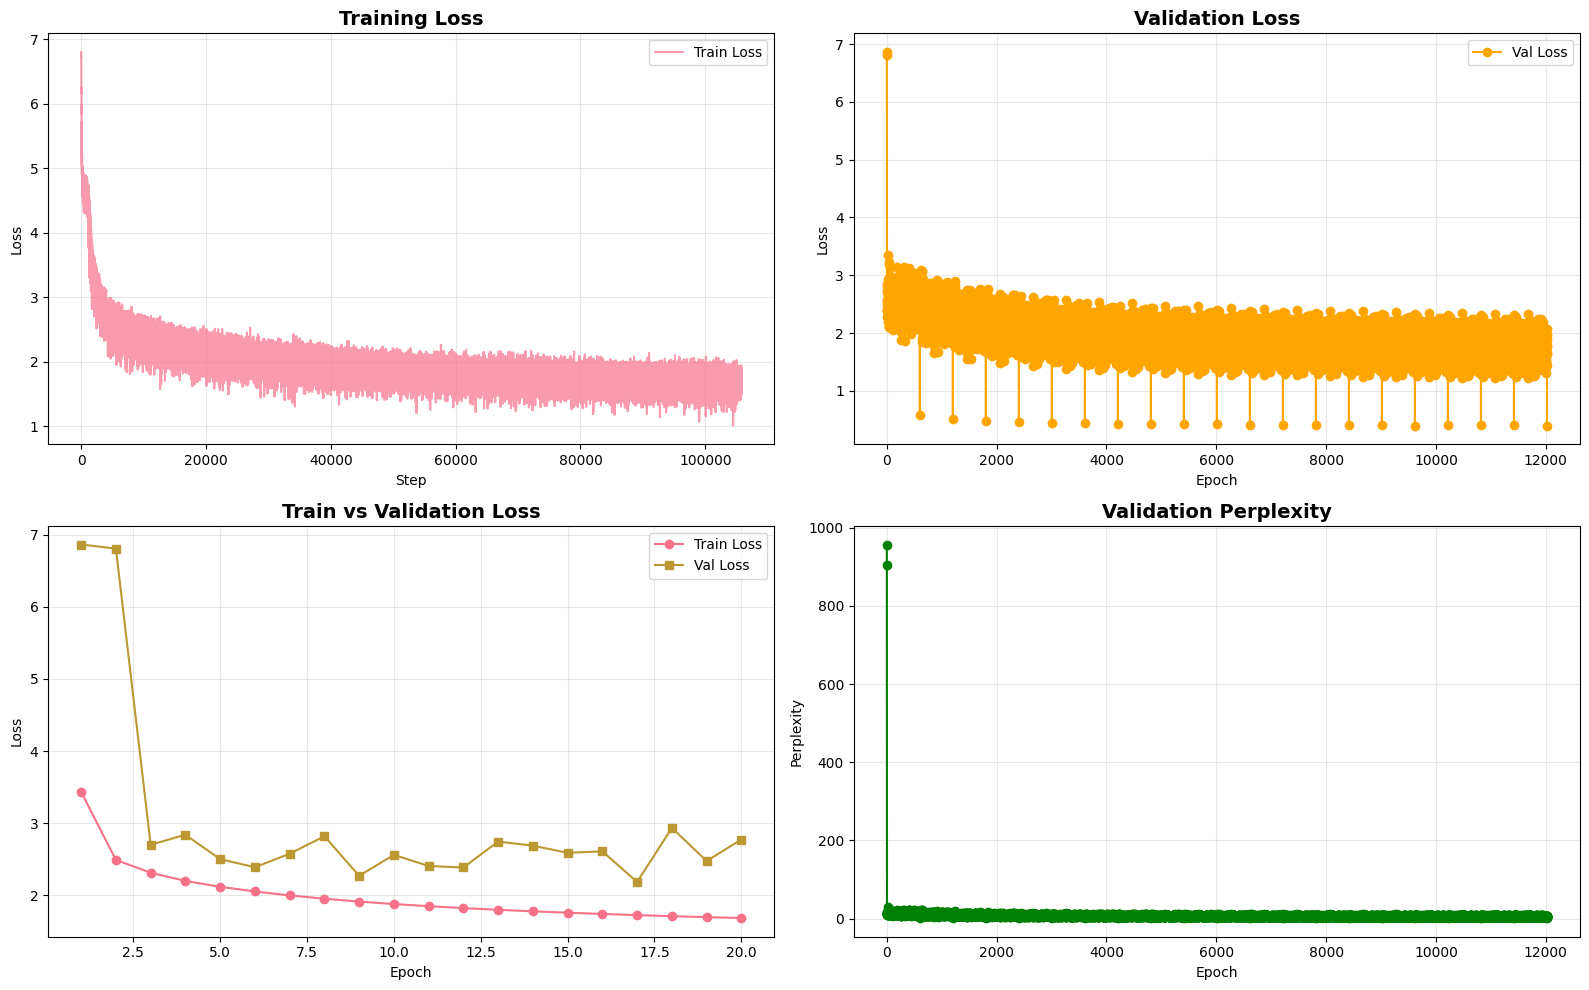

Graphiques sauvegardés: logs/training_curves.png


In [10]:
# On charge les logs depuis le modèle
train_losses = model.train_loss_history
val_losses = model.val_loss_history

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Loss d'entraînement
if train_losses:
    axes[0, 0].plot(train_losses, alpha=0.7, label='Train Loss')
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Loss de validation
if val_losses:
    axes[0, 1].plot(val_losses, color='orange', marker='o', label='Val Loss')
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Comparaison Train vs Val 
if train_losses and val_losses:
    # Moyenner les train losses par epoch
    steps_per_epoch = len(train_loader)
    train_losses_per_epoch = [
        np.mean(train_losses[i*steps_per_epoch:(i+1)*steps_per_epoch])
        for i in range(min(len(val_losses), len(train_losses) // steps_per_epoch))
    ]
    
    epochs = range(1, len(train_losses_per_epoch) + 1)
    axes[1, 0].plot(epochs, train_losses_per_epoch, label='Train Loss', marker='o')
    axes[1, 0].plot(epochs, val_losses[:len(train_losses_per_epoch)], label='Val Loss', marker='s')
    axes[1, 0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 4. Perplexity
if val_losses:
    perplexities = [np.exp(loss) for loss in val_losses]
    axes[1, 1].plot(perplexities, color='green', marker='o')
    axes[1, 1].set_title('Validation Perplexity', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Perplexity')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Graphiques sauvegardés: logs/training_curves.png")

## 8. Analyse des Résultats

**Loss**:
- Train loss décroissante donc le modèle apprend
- Val loss décroissante donc pas d'overfitting
- Convergence donc le modèle a bien appris les patterns musicaux

**Perplexity**:
4.46 donc meilleures prédictions

**Accuracy**:
- % de tokens correctement prédits
- % ?

In [11]:
# Statistiques finales
if val_losses:
    final_val_loss = val_losses[-1]
    final_perplexity = np.exp(final_val_loss)
    
    print("Statistiques finales:")
    print(f"Epochs complétés: {len(val_losses)}")
    print(f"Meilleure val loss: {min(val_losses):.4f}")
    print(f"Val loss finale: {final_val_loss:.4f}")
    print(f"Perplexity finale: {final_perplexity:.2f}")
    print(f"Amélioration: {((val_losses[0] - min(val_losses)) / val_losses[0] * 100):.1f}%")

Statistiques finales:
Epochs complétés: 12022
Meilleure val loss: 0.3988
Val loss finale: 0.3988
Perplexity finale: 1.49
Amélioration: 94.2%


In [12]:
# On sauvegarde le résumé de l'entraînement
summary = {
    'model_config': MODEL_CONFIG,
    'training_config': TRAINING_CONFIG,
    'vocab_size': vocab_size,
    'num_parameters': num_params,
    'best_model_path': str(best_model_path),
    'best_val_loss': float(best_val_loss),
    'final_val_loss': float(val_losses[-1]) if val_losses else None,
    'epochs_completed': len(val_losses) if val_losses else 0
}

summary_path = LOG_DIR / 'training_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Résumé sauvegardé: {summary_path}")

Résumé sauvegardé: ..\logs\training_summary.json
